# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [24]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import gdown

The next cells contain instructions for downloading data.
**Please, make your own copy.**

In [ ]:
#data
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
#dates
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE

In [ ]:
#land-sea mask
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK

In [ ]:
#a statistical baseline
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ

Le us inspect and visualize data.

In [25]:
x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

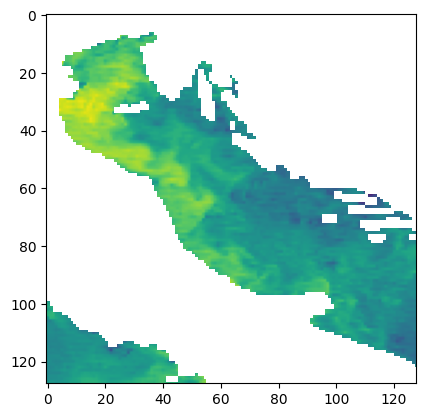

In [26]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds
plt.show()

In [27]:
dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


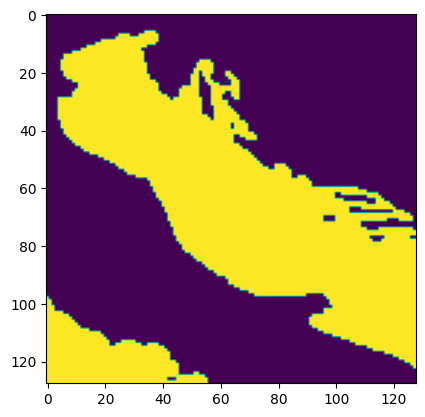

In [28]:
land_sea_mask = np.load('/content/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [29]:
baseline = np.load('/content/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


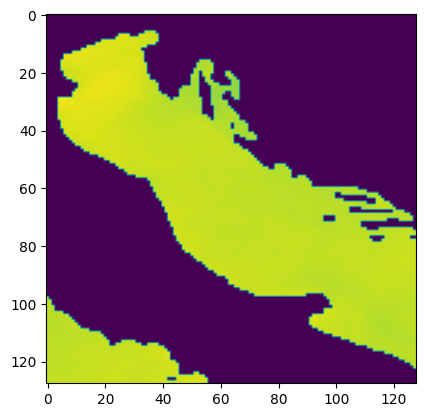

In [30]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [31]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [32]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [33]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [34]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [35]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 28.34499952548174
image 0; 0.0, 28.34499952548174
image 1; 0.0, 28.019998853277343
image 2; 0.0, 26.41425441292114


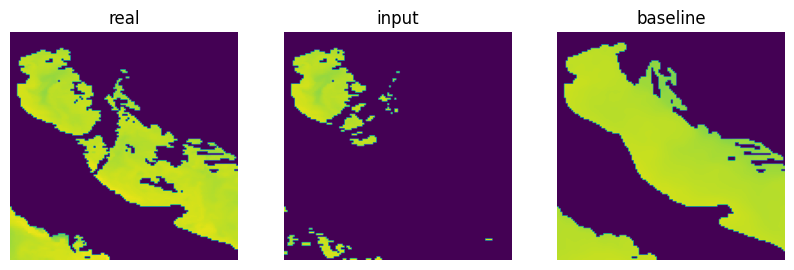

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


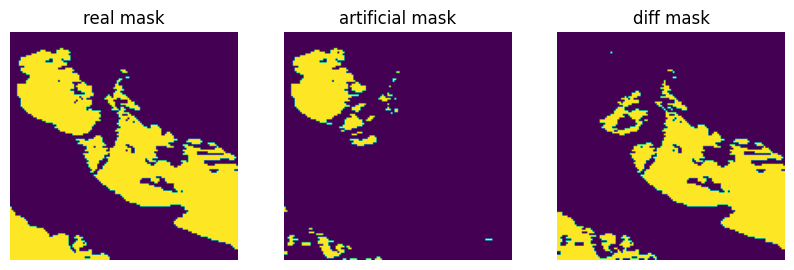

In [36]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [37]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6295785307298681
RMSE std : 0.18999208628087152


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


# My Project

The generator was wrapped inside a new one to modify the shapes of `batch_x` and `batch_y` specifically for training. A **UNet** architecture is employed to reconstruct the real image from a three-channel input tensor:

**batch_x** (Input tensor with three channels):
* The first channel contains the <u>input image</u>.
* The second channel identifies <u>areas of the image that require reconstruction</u>.
* The third channel provides the <u>baseline temperature</u>.

**batch_y** (Target tensor with two channels):

* The first channel represents the <u>real image</u>, which the network aims to reconstruct as accurately as possible.
* The second channel contains a mask that is used to focus the loss calculation only on the parts of the image that require precise reconstruction.

In [38]:
def wrapped_generator(batch_size, dataset, dates):
    gen = generator(batch_size, dataset, dates)

    while True:
        batch_x, batch_y = next(gen)

        new_batch_x = np.zeros((batch_size, batch_x.shape[1], batch_x.shape[2], 3))
        new_batch_y = np.zeros((batch_size, batch_y.shape[1], batch_y.shape[2], 2))

        for b in range(batch_size):
            new_batch_x[b, ..., 0] = batch_x[b, ..., 0]
            new_batch_x[b, ..., 1] = (batch_x[b, ..., 1] - batch_x[b, ..., 2])
            new_batch_x[b, ..., 2] = batch_x[b, ..., 3]

            new_batch_y[b, ..., 0] = batch_y[b, ..., 0]
            new_batch_y[b, ..., 1] = batch_y[b, ..., 1]

        yield new_batch_x, new_batch_y

batch_size = 32
train_gen = wrapped_generator(batch_size, x_train_n, dates_train_n)
val_gen = wrapped_generator(batch_size, x_val_n, dates_val_n)

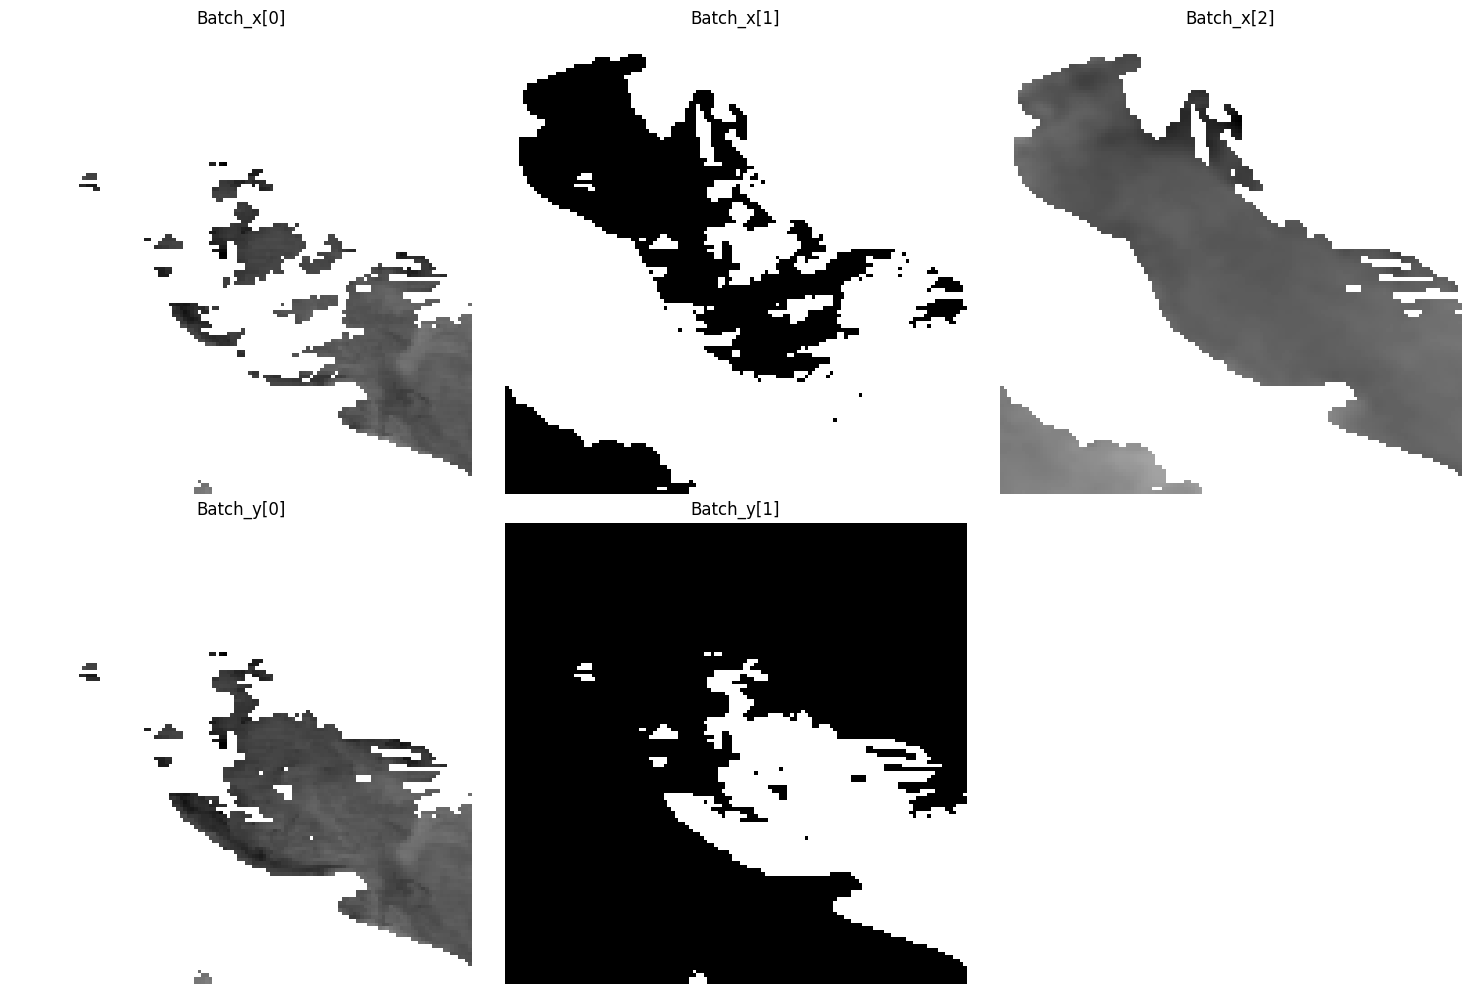

In [54]:
import matplotlib.pyplot as plt

def plot_batch(train_gen, batch_index=0):
    train_x, train_y = next(train_gen)

    num_channels_x = train_x.shape[3]
    num_channels_y = train_y.shape[3]

    fig, axes = plt.subplots(2, max(num_channels_x, num_channels_y), figsize=(15, 10))

    for i in range(num_channels_x):
        axes[0, i].imshow(train_x[batch_index, ..., i], cmap="gray")
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Batch_x[{i}]")

    for i in range(num_channels_y):
        axes[1, i].imshow(train_y[batch_index, ..., i], cmap="gray")
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Batch_y[{i}]")

    for i in range(num_channels_y, max(num_channels_x, num_channels_y)):
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Batch X", rotation=90, labelpad=15)
    axes[1, 0].set_ylabel("Batch Y", rotation=90, labelpad=15)

    plt.tight_layout()
    plt.show()

plot_batch(train_gen)


## My Model

Various configurations of U-Net were tested, including `Inception` blocks, `Squeeze-and-Excitation` blocks, and different backbones (`EfficientNetB0`, `ResNet50`) for the encoder. However, none performed as well as the configuration inspired by [Attention U-Net](https://arxiv.org/pdf/1804.03999). This approach uses <u>residual blocks and attention gates</u> to highlight relevant features and suppress less important ones, enabling the model to focus on significant areas for sea surface temperature prediction. Similar to the gates in LSTM networks, the attention mechanism filters or emphasizes the signal during image reconstruction.

In [62]:
def conv_block(inputs, num_filters, kernel_size=3, use_batchnorm=True, dropout_rate=0.1):
    x = layers.Conv2D(num_filters, kernel_size, padding="same")(inputs)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(num_filters, kernel_size, padding="same")(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def attention_gate(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1))(x)
    phi_g = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1))(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, (1, 1), strides=(1, 1))(f)
    rate = layers.Activation('sigmoid')(psi_f)
    att_x = layers.multiply([x, rate])
    return att_x

def residual_block(x, filters):
    res = layers.Conv2D(filters, 3, padding='same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.Activation('relu')(res)
    res = layers.Conv2D(filters, 3, padding='same')(res)
    res = layers.BatchNormalization()(res)

    shortcut = layers.Conv2D(filters, 1, padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)

    output = layers.Add()([shortcut, res])
    return layers.Activation('relu')(output)

def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    e1 = residual_block(inputs, 64)
    e2 = residual_block(layers.MaxPooling2D()(e1), 128)
    e3 = residual_block(layers.MaxPooling2D()(e2), 256)
    e4 = residual_block(layers.MaxPooling2D()(e3), 512)

    # Bridge
    b = residual_block(layers.MaxPooling2D()(e4), 1024)

    # Decoder
    d4 = layers.Conv2DTranspose(512, (2, 2), strides=2, padding="same")(b)
    d4 = attention_gate(e4, d4, 256)
    d4 = layers.Concatenate()([d4, e4])
    d4 = residual_block(d4, 512)

    d3 = layers.Conv2DTranspose(256, (2, 2), strides=2, padding="same")(d4)
    d3 = attention_gate(e3, d3, 128)
    d3 = layers.Concatenate()([d3, e3])
    d3 = residual_block(d3, 256)

    d2 = layers.Conv2DTranspose(128, (2, 2), strides=2, padding="same")(d3)
    d2 = attention_gate(e2, d2, 64)
    d2 = layers.Concatenate()([d2, e2])
    d2 = residual_block(d2, 128)

    d1 = layers.Conv2DTranspose(64, (2, 2), strides=2, padding="same")(d2)
    d1 = attention_gate(e1, d1, 32)
    d1 = layers.Concatenate()([d1, e1])
    d1 = residual_block(d1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='linear')(d1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet(input_shape=(128, 128, 3))
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_139 (Conv2D)       │ (None, 128, 128, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 128, 128, 64)   │            256 │ conv2d_139[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 128, 128, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_141 (Conv2D)       │ (None, 128, 128, 64)   │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_140 (Conv2D)       │ (None, 128, 128, 64)   │         36,928 │ activation_96[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_101   │ (None, 128, 128, 64)   │            256 │ conv2d_141[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 128, 128, 64)   │            256 │ conv2d_140[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_39 (Add)              │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 128, 128, 64)   │              0 │ add_39[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 64)     │              0 │ activation_97[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_142 (Conv2D)       │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_102   │ (None, 64, 64, 128)    │            512 │ conv2d_142[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_98             │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_144 (Conv2D)  

 Total params: 32,812,453 (125.17 MB)

 Trainable params: 32,794,789 (125.10 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [65]:
# optimizer
optimizer = keras.optimizers.Adam()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

To have full control over the training process and loss calculation, I rewrote the training procedure using TensorFlow APIs. The loss function, as previously explained, is a masked loss calculated only in the diff mask area. Additionally, I combined the `MSE loss` with a `smoothness loss`, which aims to make contiguous values more similar, reflecting the natural continuity of sea temperatures.

The model was trained for 128 epochs, for a total of ~37000 steps.

In [ ]:
from tqdm.auto import tqdm

def masked_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_sst, mask = tf.split(y_true, 2, axis=-1)

    mse_loss = tf.reduce_mean(tf.square(y_pred - y_true_sst) * mask)

    total_loss = mse_loss + 0.1 * smoothness_loss(y_pred, mask)
    return mse_loss

def smoothness_loss(y_pred, cloud_mask):
    diff_x = tf.abs(y_pred[:, 1:, :] - y_pred[:, :-1, :]) * cloud_mask[:, 1:, :]
    diff_y = tf.abs(y_pred[:, :, 1:] - y_pred[:, :, :-1]) * cloud_mask[:, :, 1:]

    smooth_loss = tf.reduce_mean(diff_x) + tf.reduce_mean(diff_y)
    return smooth_loss

@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = masked_loss(y, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(model, x, y):
    preds = model(x, training=False)
    loss = masked_loss(y, preds)
    return loss

def train(model, train_gen, val_gen, epochs, optimizer, train_steps, val_steps, patience=40):
    best_val_rmse = float('inf')
    patience_counter = 0
    total_steps = epochs * train_steps

    with tqdm(total=total_steps, desc="Training Steps", unit="step") as pbar:
        for epoch in range(epochs):
            # Train
            train_loss = tf.keras.metrics.Mean()
            train_rmse = tf.keras.metrics.Mean()

            for _ in range(train_steps):
                batch_x, batch_y = next(train_gen)
                loss = train_step(model, optimizer, batch_x, batch_y)
                train_loss.update_state(loss)
                train_rmse.update_state(tf.sqrt(loss))
                pbar.set_postfix({
                    "Train Loss": f"{train_loss.result().numpy():.4f}",
                    "Train RMSE": f"{train_rmse.result().numpy():.4f}"
                })
                pbar.update(1)

            # Val
            val_loss = tf.keras.metrics.Mean()
            val_rmse = tf.keras.metrics.Mean()

            for _ in range(val_steps):
                batch_x, batch_y = next(val_gen)
                loss = val_step(model, batch_x, batch_y)
                val_loss.update_state(loss)
                val_rmse.update_state(tf.sqrt(loss))

            # Log results
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.result().numpy():.4f}, "
                  f"Train RMSE: {train_rmse.result().numpy():.4f}, "
                  f"Val Loss: {val_loss.result().numpy():.4f}, Val RMSE: {val_rmse.result().numpy():.4f}")

             # Save the model
            if val_rmse.result().numpy() < best_val_rmse:
                best_val_rmse = val_rmse.result().numpy()
                model_path = f"/content/drive/MyDrive/best_model_epoch_{epoch+1}.keras"
                model.save(model_path)
                print(f"Model saved at epoch {epoch+1} with Val RMSE: {best_val_rmse:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"No improvement for {patience_counter} epoch(s)")

            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in {patience} epochs.")
                break


epochs = 200
train_steps = len(x_train_n) // batch_size
val_steps = len(x_val_n) // batch_size

train(model, train_gen, val_gen, epochs, optimizer, train_steps, val_steps)

Training Steps:   0%|          | 0/36400 [00:00<?, ?step/s]

Epoch 1/200, Train Loss: 0.0323, Train RMSE: 0.1366, Val Loss: 0.1077, Val RMSE: 0.3276
Model saved at epoch 1 with Val RMSE: 0.3276
Epoch 2/200, Train Loss: 0.0083, Train RMSE: 0.0900, Val Loss: 0.0354, Val RMSE: 0.1876
Model saved at epoch 2 with Val RMSE: 0.1876
Epoch 3/200, Train Loss: 0.0066, Train RMSE: 0.0809, Val Loss: 0.0087, Val RMSE: 0.0931
Model saved at epoch 3 with Val RMSE: 0.0931
Epoch 4/200, Train Loss: 0.0062, Train RMSE: 0.0784, Val Loss: 0.0044, Val RMSE: 0.0663
Model saved at epoch 4 with Val RMSE: 0.0663
Epoch 5/200, Train Loss: 0.0056, Train RMSE: 0.0743, Val Loss: 0.0061, Val RMSE: 0.0780
No improvement for 1 epoch(s)
Epoch 6/200, Train Loss: 0.0049, Train RMSE: 0.0699, Val Loss: 0.0040, Val RMSE: 0.0630
Model saved at epoch 6 with Val RMSE: 0.0630
Epoch 7/200, Train Loss: 0.0050, Train RMSE: 0.0705, Val Loss: 0.0044, Val RMSE: 0.0666
No improvement for 1 epoch(s)
Epoch 8/200, Train Loss: 0.0045, Train RMSE: 0.0669, Val Loss: 0.0106, Val RMSE: 0.1025
No improvem

In [ ]:
model.load_weights(f"/content/drive/MyDrive/best_model_epoch_{120}.keras")

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
train(model, train_gen, val_gen, optimizer, 100, train_steps, val_steps)

Training Steps:   0%|          | 0/18200 [00:00<?, ?step/s]

Epoch 1/100, Train Loss: 0.0022, Train RMSE: 0.0469, Val Loss: 0.0022, Val RMSE: 0.0463
Model saved at epoch 1 with Val RMSE: 0.0463
Epoch 2/100, Train Loss: 0.0022, Train RMSE: 0.0470, Val Loss: 0.0021, Val RMSE: 0.0455
Model saved at epoch 2 with Val RMSE: 0.0455
Epoch 3/100, Train Loss: 0.0023, Train RMSE: 0.0474, Val Loss: 0.0022, Val RMSE: 0.0469
No improvement for 1 epoch(s)
Epoch 4/100, Train Loss: 0.0022, Train RMSE: 0.0467, Val Loss: 0.0020, Val RMSE: 0.0449
Model saved at epoch 4 with Val RMSE: 0.0449
Epoch 5/100, Train Loss: 0.0022, Train RMSE: 0.0468, Val Loss: 0.0021, Val RMSE: 0.0452
No improvement for 1 epoch(s)
Epoch 6/100, Train Loss: 0.0022, Train RMSE: 0.0465, Val Loss: 0.0021, Val RMSE: 0.0462
No improvement for 2 epoch(s)
Epoch 7/100, Train Loss: 0.0022, Train RMSE: 0.0466, Val Loss: 0.0021, Val RMSE: 0.0461
No improvement for 3 epoch(s)
Epoch 8/100, Train Loss: 0.0022, Train RMSE: 0.0465, Val Loss: 0.0019, Val RMSE: 0.0438
Model saved at epoch 8 with Val RMSE: 0.0

In [ ]:
model.load_weights(f"/content/drive/MyDrive/best_model_epoch_{8}.keras")

For evaluation, we wrap the original generator in a new generator where `batch_x` is processed as described earlier, while `batch_y` remains unchanged. This ensures compatibility with the evaluation procedure.

In [ ]:
def wrapped_generator2(batch_size, dataset, dates):
    gen = generator(batch_size, dataset, dates)

    while True:
        batch_x, batch_y = next(gen)

        new_batch_x = np.zeros((batch_size, batch_x.shape[1], batch_x.shape[2], 3))

        for b in range(batch_size):
            new_batch_x[b, ..., 0] = batch_x[b, ..., 0]
            new_batch_x[b, ..., 1] = (batch_x[b, ..., 1] - batch_x[b, ..., 2])
            new_batch_x[b, ..., 2] = batch_x[b, ..., 3]

        yield new_batch_x, batch_y

batch_size = 32
test_gen = wrapped_generator2(batch_size, x_test_n, dates_test_n)

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model.predict(batch_x, verbose=0)
    # predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm[...,0] - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.4497616849122512
RMSE std : 0.14700348778416855


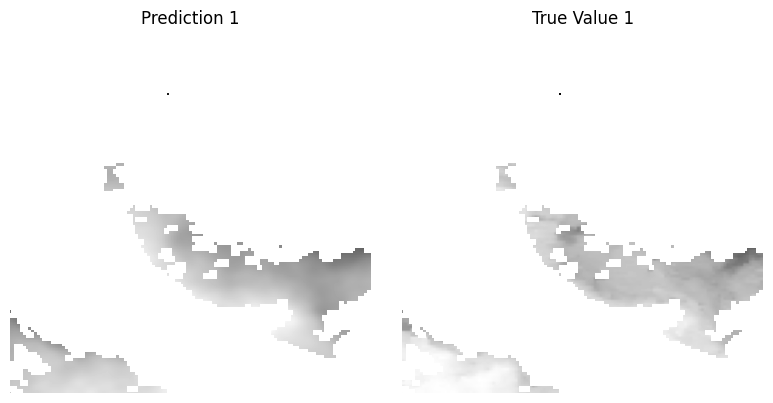

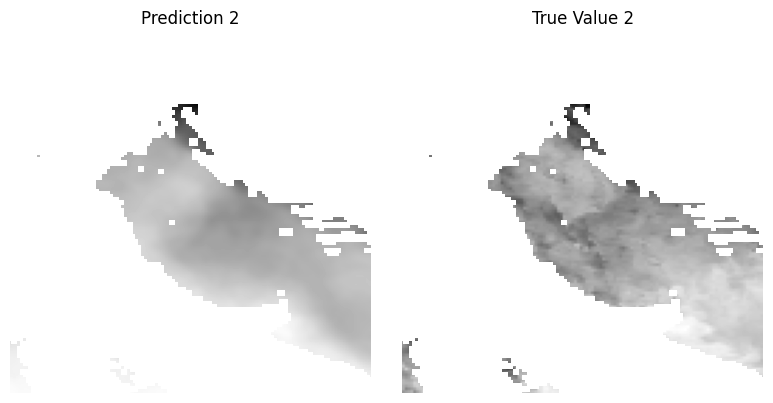

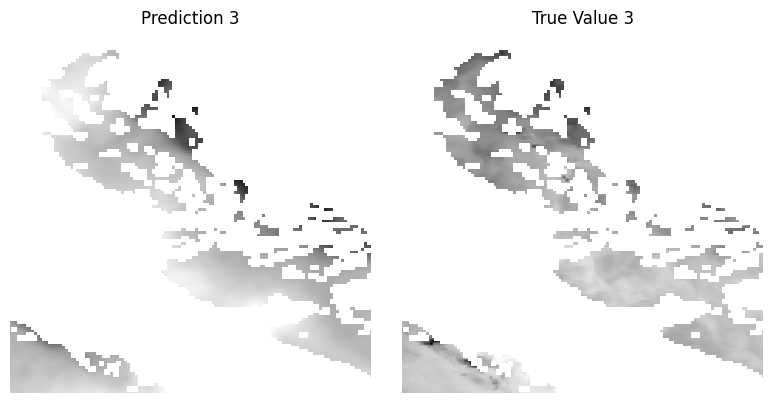

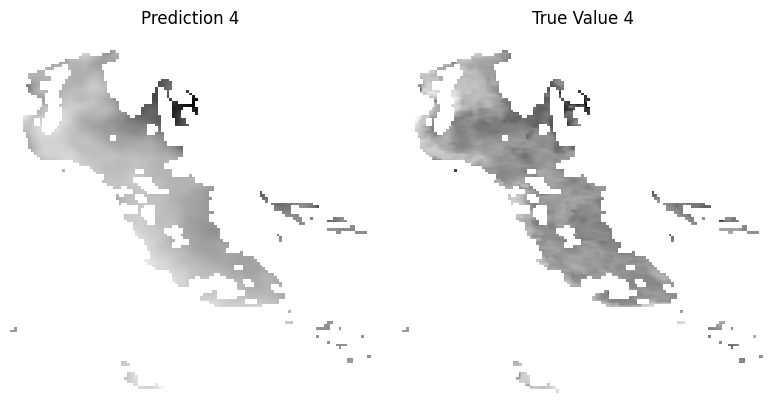

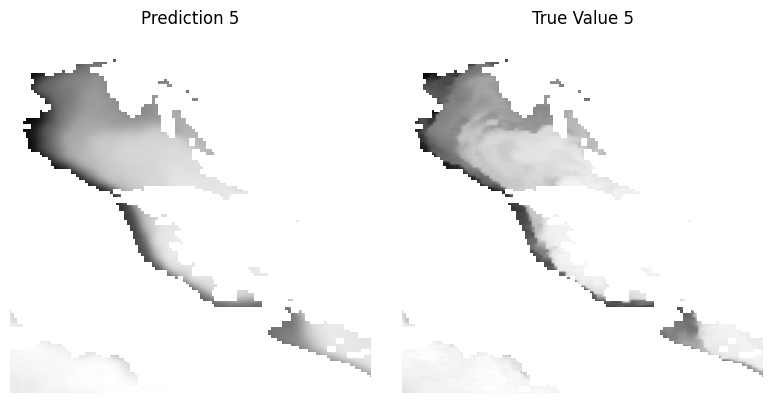

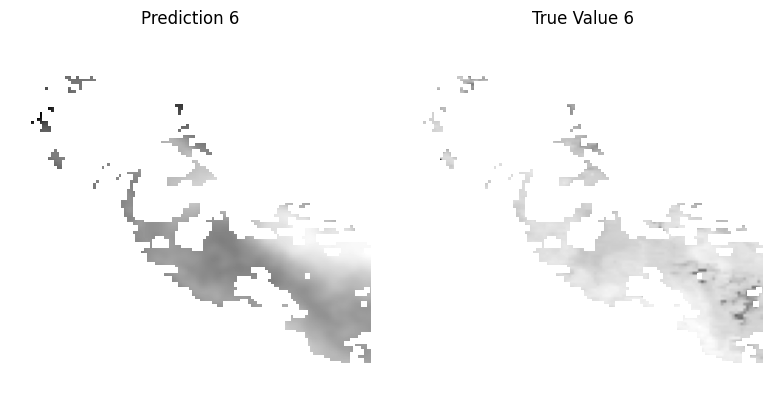

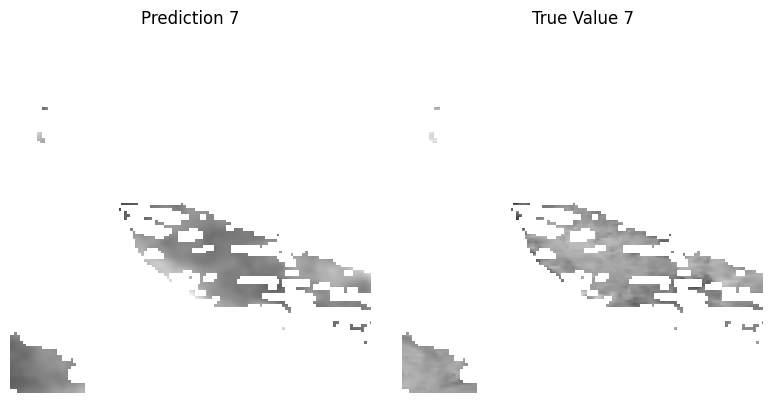

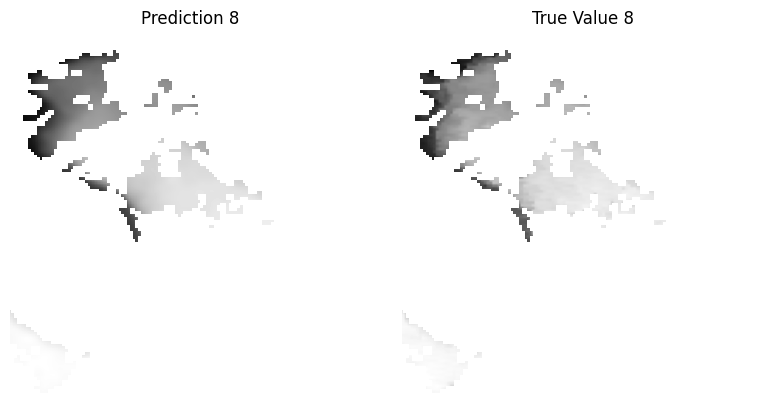

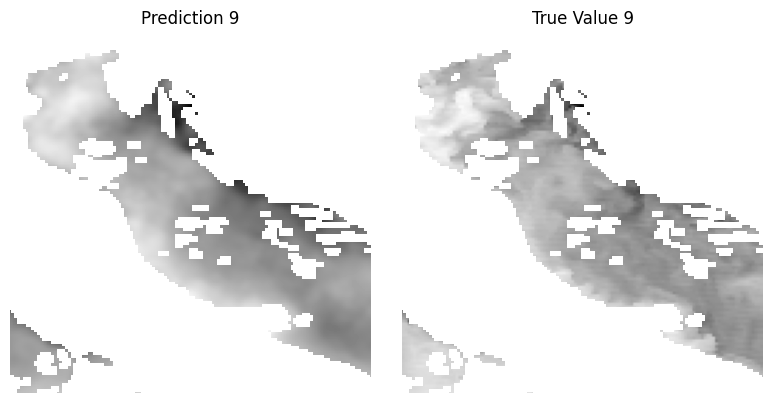

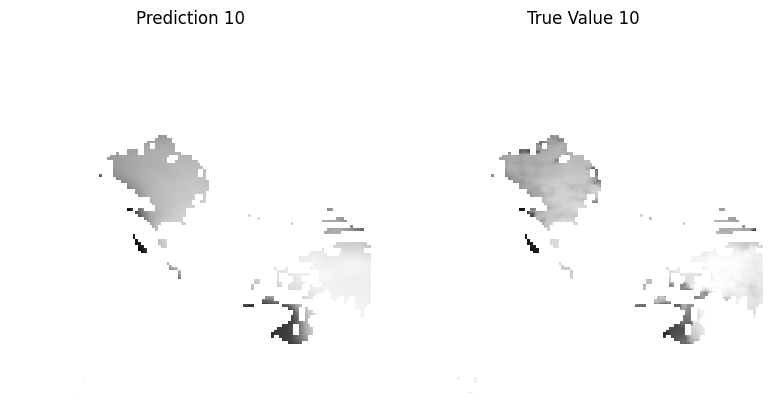

In [79]:
num_examples = 10

for i in range(num_examples):
    plt.figure(figsize=(8, 4))

    # Plot prediction with mask
    plt.subplot(1, 2, 1)
    masked_prediction = np.where(diffMask[i], predictions_denorm[i], np.nan)
    plt.imshow(masked_prediction, cmap="gray")
    plt.title(f"Prediction {i+1}")
    plt.axis('off')

    # Plot true value with mask
    plt.subplot(1, 2, 2)
    masked_true_value = np.where(diffMask[i], true_values_denorm[i], np.nan)
    plt.imshow(masked_true_value, cmap="gray")
    plt.title(f"True Value {i+1}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()